# saved models are named as FreeSound_1D_conv_

In [1]:
import os
import pickle
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'free_sound_11025.pkl',
 'free_sound_22050.pkl',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [15]:
pickle.dump(Loaded_data, open('data/freesound-audio-tagging/free_sound_11025.pkl', 'wb'))

In [3]:
Loaded_data = {}
if os.path.exists('data/freesound-audio-tagging/free_sound_11025.pkl'):
    Loaded_data = pickle.load(open('data/freesound-audio-tagging/free_sound_11025.pkl', 'rb'))
    
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

def load_audio_file(file_path, input_length=4096):
    
    if file_path not in Loaded_data:
        data = librosa.core.load(file_path, sr=None) 
        data = librosa.core.resample(data[0], data[1], 11025)
        Loaded_data[file_path] = data
    else:
        data = Loaded_data[file_path]
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

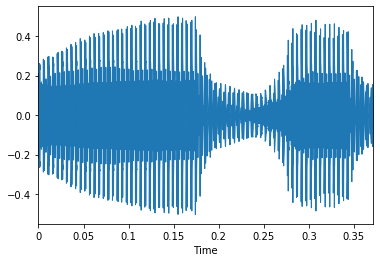

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=11025, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [7]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.input_length = 4096
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [8]:
sr = 11025
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [9]:
mini_batch_size = 96
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=mini_batch_size, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=mini_batch_size, shuffle=True)

In [10]:
FreeSoundData[0][0].shape

(1, 4096)

# Model

In [11]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_96_3 = nn.Conv1d(in_channels=32, out_channels=96, kernel_size=3, padding=True)
        self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_96_64 = nn.Linear(in_features=96, out_features=64)
        self.fc_64_512 = nn.Linear(in_features=64, out_features=512)
        self.fc_512_42 = nn.Linear(in_features=512, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_96_3(x)
        x = self.relu(x)
        x = self.conv1d_96_96_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_96_64(x)
        x = self.relu(x)
        x = self.fc_64_512(x)
        x = self.relu(x)
        x = self.fc_512_42(x)
        x = self.softmax(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4090]             160
              ReLU-2             [-1, 16, 4090]               0
            Conv1d-3             [-1, 16, 4084]           2,320
              ReLU-4             [-1, 16, 4084]               0
         MaxPool1d-5              [-1, 16, 255]               0
           Dropout-6              [-1, 16, 255]               0
            Conv1d-7              [-1, 32, 255]           1,568
              ReLU-8              [-1, 32, 255]               0
            Conv1d-9              [-1, 32, 255]           3,104
             ReLU-10              [-1, 32, 255]               0
        MaxPool1d-11               [-1, 32, 63]               0
          Dropout-12               [-1, 32, 63]               0
           Conv1d-13               [-1, 32, 63]           3,104
             ReLU-14               [-1,

In [20]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
epoch_progress_bar = tqdm.tqdm(range(0, 500))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*mini_batch_size)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*mini_batch_size)))


Epoch Loss:  3.49210166327561
Train Acc  28.626054852320674



Valid Acc  27.916666666666668



Epoch Loss:  3.4850127998786635
Train Acc  29.36445147679325



Valid Acc  28.489583333333332



Epoch Loss:  3.4877251069757005
Train Acc  28.995253164556964



Valid Acc  28.333333333333332



Epoch Loss:  3.4830806768393217
Train Acc  29.496308016877638



Valid Acc  27.760416666666668



Epoch Loss:  3.491167391402812
Train Acc  28.65242616033755



Valid Acc  28.385416666666668



Epoch Loss:  3.4878930954993526
Train Acc  28.929324894514767



Valid Acc  29.166666666666668



Epoch Loss:  3.487376062175896
Train Acc  29.11392405063291



Valid Acc  27.96875



Epoch Loss:  3.488058527813682
Train Acc  29.03481012658228



Valid Acc  29.427083333333332



Epoch Loss:  3.4849371487581275
Train Acc  29.074367088607595



Valid Acc  28.802083333333332



Epoch Loss:  3.4845227410521686
Train Acc  29.311708860759495



Valid Acc  28.4375



Epoch Loss:  3.4840024754970886
Train Acc  29.35126582278481



Valid Acc  27.760416666666668



Epoch Loss:  3.489005022411105
Train Acc  28.942510548523206



Valid Acc  28.28125



Epoch Loss:  3.486371103721329
Train Acc  28.98206751054852



Valid Acc  28.75



Epoch Loss:  3.4858860305592985
Train Acc  29.15348101265823



Valid Acc  28.4375



Epoch Loss:  3.4833411083945744
Train Acc  29.4831223628692



Valid Acc  28.28125



Epoch Loss:  3.492445191250572
Train Acc  28.3623417721519



Valid Acc  29.84375



Epoch Loss:  3.4922747370562974
Train Acc  28.718354430379748



Valid Acc  28.59375



Epoch Loss:  3.492029703116115
Train Acc  28.599683544303797



Valid Acc  30.208333333333332



Epoch Loss:  3.487827617910844
Train Acc  28.968881856540083



Valid Acc  28.28125



Epoch Loss:  3.485901805418956
Train Acc  29.140295358649787



Valid Acc  28.385416666666668



Epoch Loss:  3.4880262718924993
Train Acc  28.955696202531644



Valid Acc  28.802083333333332



Epoch Loss:  3.486623552781117
Train Acc  29.047995780590718



Valid Acc  28.802083333333332



Epoch Loss:  3.4864138953293424
Train Acc  29.10073839662447



Valid Acc  27.34375



Epoch Loss:  3.483351689350756
Train Acc  29.298523206751057



Valid Acc  27.135416666666668



Epoch Loss:  3.48776359799542
Train Acc  28.955696202531644



Valid Acc  28.125



Epoch Loss:  3.4879507384722745
Train Acc  28.91613924050633



Valid Acc  27.760416666666668



Epoch Loss:  3.484829299057586
Train Acc  29.324894514767934



Valid Acc  28.072916666666668



Epoch Loss:  3.4935606280459632
Train Acc  28.296413502109704



Valid Acc  28.333333333333332



Epoch Loss:  3.481231170364573
Train Acc  29.57542194092827



Valid Acc  28.90625



Epoch Loss:  3.4843139105205294
Train Acc  29.324894514767934



Valid Acc  29.0625



Epoch Loss:  3.4793237523187566
Train Acc  29.733649789029535



Valid Acc  27.03125



Epoch Loss:  3.483559705034087
Train Acc  29.390822784810126



Valid Acc  28.385416666666668



Epoch Loss:  3.4867506751531288
Train Acc  29.140295358649787



Valid Acc  27.96875



Epoch Loss:  3.482647458209267
Train Acc  29.509493670886076



Valid Acc  27.760416666666668



Epoch Loss:  3.481943299498739
Train Acc  29.601793248945146



Valid Acc  27.395833333333332



Epoch Loss:  3.4866162161283856
Train Acc  29.074367088607595



Valid Acc  27.864583333333332



Epoch Loss:  3.4875464560110356
Train Acc  29.087552742616033



Valid Acc  28.75



Epoch Loss:  3.4845721963085707
Train Acc  29.36445147679325



Valid Acc  28.489583333333332



Epoch Loss:  3.4841993307765526
Train Acc  29.390822784810126



Valid Acc  28.645833333333332



Epoch Loss:  3.488598017752925
Train Acc  28.98206751054852



Valid Acc  28.59375



Epoch Loss:  3.4843177372896217
Train Acc  29.456751054852322



Valid Acc  29.114583333333332



Epoch Loss:  3.4828984465780137
Train Acc  29.430379746835442



Valid Acc  28.697916666666668



Epoch Loss:  3.485285430014888
Train Acc  29.15348101265823



Valid Acc  27.135416666666668



Epoch Loss:  3.4846093805530405
Train Acc  29.272151898734176



Valid Acc  28.541666666666668



Epoch Loss:  3.4788992012603375
Train Acc  29.878691983122362



Valid Acc  27.8125



Epoch Loss:  3.4858478111556814
Train Acc  29.193037974683545



Valid Acc  29.166666666666668



Epoch Loss:  3.485070310061491
Train Acc  29.206223628691983



Valid Acc  29.21875



Epoch Loss:  3.4886559927010836
Train Acc  29.03481012658228



Valid Acc  29.322916666666668



Epoch Loss:  3.4894451491440397
Train Acc  28.718354430379748



Valid Acc  27.864583333333332



Epoch Loss:  3.48312231256992
Train Acc  29.390822784810126



Valid Acc  28.59375



Epoch Loss:  3.4800457260276696
Train Acc  29.667721518987342



Valid Acc  28.802083333333332



Epoch Loss:  3.4846233718002897
Train Acc  29.15348101265823



Valid Acc  29.947916666666668



Epoch Loss:  3.4847551538974426
Train Acc  29.285337552742615



Valid Acc  28.229166666666668



Epoch Loss:  3.4836448597002634
Train Acc  29.509493670886076



Valid Acc  27.5



Epoch Loss:  3.486476572254036
Train Acc  28.98206751054852



Valid Acc  28.958333333333332



Epoch Loss:  3.4839920062053054
Train Acc  29.390822784810126



Valid Acc  27.604166666666668



Epoch Loss:  3.4855904579162598
Train Acc  29.258966244725737



Valid Acc  28.4375



Epoch Loss:  3.4845988448662095
Train Acc  29.430379746835442



Valid Acc  28.28125



Epoch Loss:  3.4811514359486253
Train Acc  29.614978902953588



Valid Acc  28.072916666666668



Epoch Loss:  3.481327920020381
Train Acc  29.614978902953588



Valid Acc  27.916666666666668



Epoch Loss:  3.485528701468359
Train Acc  29.219409282700422



Valid Acc  29.427083333333332



Epoch Loss:  3.4800821195674847
Train Acc  29.746835443037973



Valid Acc  29.427083333333332



Epoch Loss:  3.4836020680922495
Train Acc  29.417194092827003



Valid Acc  27.708333333333332



Epoch Loss:  3.481919059270545
Train Acc  29.614978902953588



Valid Acc  29.166666666666668



Epoch Loss:  3.483519671838495
Train Acc  29.390822784810126



Valid Acc  29.53125



Epoch Loss:  3.483190780953516
Train Acc  29.404008438818565



Valid Acc  29.479166666666668



Epoch Loss:  3.4785444615762446
Train Acc  29.90506329113924



Valid Acc  28.645833333333332



Epoch Loss:  3.4830746499797964
Train Acc  29.46993670886076



Valid Acc  28.854166666666668



Epoch Loss:  3.4866036342669138
Train Acc  29.074367088607595



Valid Acc  28.697916666666668



Epoch Loss:  3.488611815850946
Train Acc  28.863396624472575



Valid Acc  28.229166666666668



Epoch Loss:  3.487081008621409
Train Acc  29.061181434599156



Valid Acc  27.395833333333332



Epoch Loss:  3.4829960684233074
Train Acc  29.535864978902953



Valid Acc  29.375



Epoch Loss:  3.4797224153446247
Train Acc  29.8918776371308



Valid Acc  28.958333333333332



Epoch Loss:  3.4874823002875606
Train Acc  28.98206751054852



Valid Acc  27.708333333333332



Epoch Loss:  3.4858242650575275
Train Acc  29.11392405063291



Valid Acc  29.270833333333332



Epoch Loss:  3.4823791377152067
Train Acc  29.601793248945146



Valid Acc  28.802083333333332



Epoch Loss:  3.4771452945998953
Train Acc  30.050105485232066



Valid Acc  28.75



Epoch Loss:  3.481920586356634
Train Acc  29.522679324894515



Valid Acc  28.125



Epoch Loss:  3.486030092722253
Train Acc  29.074367088607595



Valid Acc  28.28125



Epoch Loss:  3.4780892118622986
Train Acc  29.970991561181435



Valid Acc  29.21875



Epoch Loss:  3.4842166327222994
Train Acc  29.44356540084388



Valid Acc  30.104166666666668



Epoch Loss:  3.4806050620501554
Train Acc  29.614978902953588



Valid Acc  28.958333333333332



Epoch Loss:  3.4816769467124455
Train Acc  29.69409282700422



Valid Acc  27.5



Epoch Loss:  3.482292232634146
Train Acc  29.390822784810126



Valid Acc  28.541666666666668



Epoch Loss:  3.4799766540527344
Train Acc  29.549050632911392



Valid Acc  28.90625



Epoch Loss:  3.484827756881714
Train Acc  29.219409282700422



Valid Acc  28.385416666666668



Epoch Loss:  3.4808406588397447
Train Acc  29.878691983122362



Valid Acc  28.28125



Epoch Loss:  3.4807745263546326
Train Acc  29.522679324894515



Valid Acc  27.760416666666668



Epoch Loss:  3.4853993065749544
Train Acc  29.338080168776372



Valid Acc  29.114583333333332



Epoch Loss:  3.4776133012168016
Train Acc  30.02373417721519



Valid Acc  29.0625



Epoch Loss:  3.481960064248194
Train Acc  29.654535864978904



Valid Acc  29.010416666666668



Epoch Loss:  3.4861549425728713
Train Acc  29.140295358649787



Valid Acc  29.6875



Epoch Loss:  3.4848751901071284
Train Acc  29.272151898734176



Valid Acc  28.4375



Epoch Loss:  3.4842189957823932
Train Acc  29.272151898734176



Valid Acc  28.802083333333332



Epoch Loss:  3.479212540614454
Train Acc  29.746835443037973



Valid Acc  28.90625



Epoch Loss:  3.4834252097938636
Train Acc  29.36445147679325



Valid Acc  29.010416666666668



Epoch Loss:  3.4791580755499343
Train Acc  29.733649789029535



Valid Acc  27.1875



Epoch Loss:  3.4838207492345497
Train Acc  29.36445147679325



Valid Acc  28.90625



Epoch Loss:  3.4785037282146987
Train Acc  29.81276371308017



Valid Acc  29.322916666666668



Epoch Loss:  3.479943236218223
Train Acc  29.839135021097047



Valid Acc  28.28125



Epoch Loss:  3.4864576798451097
Train Acc  29.02162447257384



Valid Acc  29.479166666666668



Epoch Loss:  3.486786944956719
Train Acc  29.10073839662447



Valid Acc  27.8125



Epoch Loss:  3.4785891756226746
Train Acc  30.02373417721519



Valid Acc  27.8125



Epoch Loss:  3.480536279799063
Train Acc  29.707278481012658



Valid Acc  27.5



Epoch Loss:  3.4832600098621995
Train Acc  29.404008438818565



Valid Acc  28.59375



Epoch Loss:  3.483752039414418
Train Acc  29.338080168776372



Valid Acc  28.802083333333332



Epoch Loss:  3.479843833778478
Train Acc  29.79957805907173



Valid Acc  27.604166666666668



Epoch Loss:  3.472314819504943
Train Acc  30.643459915611814



Valid Acc  28.90625



Epoch Loss:  3.482892271838611
Train Acc  29.46993670886076



Valid Acc  28.90625



Epoch Loss:  3.481020918375329
Train Acc  29.614978902953588



Valid Acc  28.697916666666668



Epoch Loss:  3.4784900991222525
Train Acc  29.93143459915612



Valid Acc  28.958333333333332



Epoch Loss:  3.4821188812014423
Train Acc  29.628164556962027



Valid Acc  28.958333333333332



Epoch Loss:  3.487719722940952
Train Acc  29.03481012658228



Valid Acc  28.072916666666668



Epoch Loss:  3.4821032059343557
Train Acc  29.614978902953588



Valid Acc  28.229166666666668



Epoch Loss:  3.478906287422663
Train Acc  30.01054852320675



Valid Acc  29.479166666666668



Epoch Loss:  3.479592317267309
Train Acc  29.733649789029535



Valid Acc  28.59375



Epoch Loss:  3.4843552203118047
Train Acc  29.311708860759495



Valid Acc  28.802083333333332



Epoch Loss:  3.478820221333564
Train Acc  29.90506329113924



Valid Acc  28.75



Epoch Loss:  3.4846634744088862
Train Acc  29.430379746835442



Valid Acc  28.854166666666668



Epoch Loss:  3.477694846406768
Train Acc  29.970991561181435



Valid Acc  28.28125



Epoch Loss:  3.4818175442611117
Train Acc  29.614978902953588



Valid Acc  29.739583333333332



Epoch Loss:  3.4782475761220426
Train Acc  30.02373417721519



Valid Acc  29.947916666666668



Epoch Loss:  3.474266299718543
Train Acc  30.234704641350213



Valid Acc  29.21875



Epoch Loss:  3.477349392975433
Train Acc  29.970991561181435



Valid Acc  30.104166666666668



Epoch Loss:  3.4786813259124756
Train Acc  29.878691983122362



Valid Acc  28.333333333333332



Epoch Loss:  3.4844140644314923
Train Acc  29.46993670886076



Valid Acc  29.21875



Epoch Loss:  3.4800321814380113
Train Acc  29.56223628691983



Valid Acc  28.802083333333332



Epoch Loss:  3.478034529504897
Train Acc  29.839135021097047



Valid Acc  30.260416666666668



Epoch Loss:  3.4785815945154503
Train Acc  29.8918776371308



Valid Acc  28.28125



Epoch Loss:  3.4808140434796297
Train Acc  29.614978902953588



Valid Acc  28.75



Epoch Loss:  3.476254771027384
Train Acc  30.14240506329114



Valid Acc  29.270833333333332



Epoch Loss:  3.4824261725703374
Train Acc  29.588607594936708



Valid Acc  29.427083333333332



Epoch Loss:  3.4794379578361028
Train Acc  29.825949367088608



Valid Acc  29.270833333333332



Epoch Loss:  3.482835006110276
Train Acc  29.549050632911392



Valid Acc  28.4375



Epoch Loss:  3.4793442834781696
Train Acc  29.90506329113924



Valid Acc  29.739583333333332



Epoch Loss:  3.48868173888967
Train Acc  28.837025316455698



Valid Acc  29.166666666666668



Epoch Loss:  3.4840371367297593
Train Acc  29.377637130801688



Valid Acc  28.802083333333332



Epoch Loss:  3.483230512353438
Train Acc  29.509493670886076



Valid Acc  29.322916666666668



Epoch Loss:  3.477978289881839
Train Acc  29.984177215189874



Valid Acc  28.697916666666668



Epoch Loss:  3.477799472929556
Train Acc  29.944620253164558



Valid Acc  29.322916666666668



Epoch Loss:  3.476827802537363
Train Acc  30.234704641350213



Valid Acc  28.854166666666668



Epoch Loss:  3.4774884996534903
Train Acc  30.1292194092827



Valid Acc  29.635416666666668



Epoch Loss:  3.477701826940609
Train Acc  30.050105485232066



Valid Acc  29.635416666666668



Epoch Loss:  3.4813668727874756
Train Acc  29.628164556962027



Valid Acc  28.541666666666668



Epoch Loss:  3.4770580665974675
Train Acc  30.168776371308017



Valid Acc  29.114583333333332



Epoch Loss:  3.4785265439673316
Train Acc  29.81276371308017



Valid Acc  29.010416666666668



Epoch Loss:  3.4733559330807457
Train Acc  30.34018987341772



Valid Acc  28.75



Epoch Loss:  3.477331894862501
Train Acc  30.089662447257385



Valid Acc  28.958333333333332



Epoch Loss:  3.4806144388416147
Train Acc  29.746835443037973



Valid Acc  28.229166666666668



Epoch Loss:  3.4776363282264033
Train Acc  30.02373417721519



Valid Acc  29.635416666666668



Epoch Loss:  3.4757792949676514
Train Acc  30.300632911392405



Valid Acc  27.864583333333332



Epoch Loss:  3.477660257605058
Train Acc  29.984177215189874



Valid Acc  27.96875



Epoch Loss:  3.4864876089216787
Train Acc  29.061181434599156



Valid Acc  28.75



Epoch Loss:  3.4808886594410184
Train Acc  29.614978902953588



Valid Acc  28.072916666666668



Epoch Loss:  3.480960151817225
Train Acc  29.667721518987342



Valid Acc  29.53125



Epoch Loss:  3.4787176289135897
Train Acc  29.839135021097047



Valid Acc  29.166666666666668



Epoch Loss:  3.480603797526299
Train Acc  29.79957805907173



Valid Acc  28.75



Epoch Loss:  3.4832375321207167
Train Acc  29.4831223628692



Valid Acc  28.75



Epoch Loss:  3.4826910888092426
Train Acc  29.417194092827003



Valid Acc  29.21875



Epoch Loss:  3.481893530374841
Train Acc  29.654535864978904



Valid Acc  29.270833333333332



Epoch Loss:  3.4791768804381165
Train Acc  29.825949367088608



Valid Acc  29.84375



Epoch Loss:  3.4810241747506057
Train Acc  29.746835443037973



Valid Acc  29.6875



Epoch Loss:  3.486512156981456
Train Acc  29.166666666666668



Valid Acc  30.208333333333332



Epoch Loss:  3.4772373905664757
Train Acc  30.063291139240505



Valid Acc  29.010416666666668



Epoch Loss:  3.476683981810944
Train Acc  30.063291139240505



Valid Acc  29.375



Epoch Loss:  3.4719546505167513
Train Acc  30.617088607594937



Valid Acc  29.739583333333332



Epoch Loss:  3.4761823098870774
Train Acc  30.26107594936709



Valid Acc  30.104166666666668



Epoch Loss:  3.4815723986565312
Train Acc  29.667721518987342



Valid Acc  28.958333333333332



Epoch Loss:  3.4823752988742878
Train Acc  29.36445147679325



Valid Acc  30.260416666666668



Epoch Loss:  3.4756412204307847
Train Acc  30.1292194092827



Valid Acc  28.4375



Epoch Loss:  3.4814524590214595
Train Acc  29.628164556962027



Valid Acc  28.4375



Epoch Loss:  3.4824865347222436
Train Acc  29.4831223628692



Valid Acc  27.864583333333332



Epoch Loss:  3.4813294893578637
Train Acc  29.654535864978904



Valid Acc  28.645833333333332



Epoch Loss:  3.476485364044769
Train Acc  30.22151898734177



Valid Acc  29.21875



Epoch Loss:  3.4800751903389076
Train Acc  29.825949367088608



Valid Acc  29.635416666666668



Epoch Loss:  3.4827874914000305
Train Acc  29.456751054852322



Valid Acc  28.75



Epoch Loss:  3.4750068368791025
Train Acc  30.27426160337553



Valid Acc  29.739583333333332



Epoch Loss:  3.4809272078019156
Train Acc  29.69409282700422



Valid Acc  28.125



Epoch Loss:  3.4792596509185016
Train Acc  29.865506329113924



Valid Acc  28.072916666666668



Epoch Loss:  3.4790744841853276
Train Acc  29.786392405063292



Valid Acc  28.802083333333332



Epoch Loss:  3.477331846575194
Train Acc  30.036919831223628



Valid Acc  30.208333333333332



Epoch Loss:  3.476119916650313
Train Acc  30.155590717299578



Valid Acc  28.541666666666668



Epoch Loss:  3.471590820747086
Train Acc  30.419303797468356



Valid Acc  30.3125



Epoch Loss:  3.4785018087942388
Train Acc  29.839135021097047



Valid Acc  28.802083333333332



Epoch Loss:  3.4829696552662908
Train Acc  29.4831223628692



Valid Acc  29.0625



Epoch Loss:  3.4849235407913786
Train Acc  29.206223628691983



Valid Acc  28.802083333333332



Epoch Loss:  3.4721915691713745
Train Acc  30.45886075949367



Valid Acc  30.260416666666668



Epoch Loss:  3.4775375293779978
Train Acc  29.8918776371308



Valid Acc  29.791666666666668



Epoch Loss:  3.476706257349328
Train Acc  30.195147679324894



Valid Acc  29.635416666666668



Epoch Loss:  3.473878151253809
Train Acc  30.35337552742616



Valid Acc  29.84375



Epoch Loss:  3.4719491306739516
Train Acc  30.72257383966245



Valid Acc  29.6875



Epoch Loss:  3.480078986928433
Train Acc  29.746835443037973



Valid Acc  29.895833333333332



Epoch Loss:  3.4741525016253507
Train Acc  30.39293248945148



Valid Acc  28.854166666666668



Epoch Loss:  3.477623194078856
Train Acc  30.116033755274263



Valid Acc  29.791666666666668



Epoch Loss:  3.4840390833118295
Train Acc  29.338080168776372



Valid Acc  29.0625



Epoch Loss:  3.4757617153698885
Train Acc  30.24789029535865



Valid Acc  28.802083333333332



Epoch Loss:  3.475760342199591
Train Acc  30.168776371308017



Valid Acc  30.104166666666668



Epoch Loss:  3.481892582736438
Train Acc  29.654535864978904



Valid Acc  29.0625



Epoch Loss:  3.474350856829293
Train Acc  30.287447257383967



Valid Acc  29.583333333333332



Epoch Loss:  3.4759367719481262
Train Acc  30.181962025316455



Valid Acc  29.21875



Epoch Loss:  3.4791180604620826
Train Acc  29.878691983122362



Valid Acc  28.958333333333332



Epoch Loss:  3.4781266526330876
Train Acc  29.970991561181435



Valid Acc  29.479166666666668


In [18]:
torch.save(Model.state_dict(), "model_weights/FreeSound_1D_conv_small_400_epoch.stDict")

In [174]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.3125 10


[(tensor(0), False),
 (tensor(3), True),
 (tensor(12), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(20), False),
 (tensor(4), False),
 (tensor(12), False),
 (tensor(34), False),
 (tensor(13), False),
 (tensor(24), False),
 (tensor(26), True),
 (tensor(7), False),
 (tensor(22), False),
 (tensor(40), True),
 (tensor(20), True),
 (tensor(17), True),
 (tensor(32), True),
 (tensor(7), False),
 (tensor(24), False),
 (tensor(29), False),
 (tensor(10), False),
 (tensor(38), True),
 (tensor(34), False),
 (tensor(30), True),
 (tensor(17), False),
 (tensor(26), True),
 (tensor(18), False),
 (tensor(12), False),
 (tensor(17), False),
 (tensor(1), False),
 (tensor(39), False)]